# Example 4: Light polarimetry

Light polarimetry consists on measuring the polarization information of a light wave, i.e., its Jones or Stokes vector.

There are different ways of implementing a light polarimeter. In this example we will describe one of the common ones: a polarimeter composed of a rotating perfect quarter-wave plate (a linear retarder with 90º retardance), a rotating perfect polarizer and a photodetector:

<img src="Light_polarimeter.png" width=495 height=320>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

from py_pol import degrees
from py_pol.jones_vector import Jones_vector
from py_pol.jones_matrix import Jones_matrix, create_Jones_matrices
from py_pol.stokes import Stokes, create_Stokes
from py_pol.mueller import Mueller, create_Mueller

## Jones formalism

During the previous example, it was explained that a Jones vector can be described using a set of four parameters. There are several possibilities. We will use intensity, alpha, delay and global phase during this example:

$E_i=\left[\begin{array}{c}
\sqrt{I}\cos(\alpha)e^{i\varphi}\\
\sqrt{I}\sin(\alpha)e^{i\left(\varphi+\delta\right)}
\end{array}\right]$.

Jones formalism uses the electric field as its main variable. However, the detector we have chosen is an intensity detector. In principle, it is not possible to measure the global phase using an intensity detector without using interferometric techniques, so first we will concentrate in measuring the other three:

$E_i=\left[\begin{array}{c}
\sqrt{I}\cos(\alpha)\\
\sqrt{I}\sin(\alpha)e^{i\delta}
\end{array}\right]$.

We can calculate analytically the parameters of the Jones vector if we choose certain angles for the retarder and the polarizer. For example, if we choose $\theta_R = 0º$, $0º$, $135º$ and $45º$, and $\theta_D = 0º$, $90º$, $0º$ and $45º$:

1. $E_{f1}=\left[\begin{array}{cc}
1 & 0\\
0 & 0
\end{array}\right]\left[\begin{array}{cc}
1 & 0\\
0 & -i
\end{array}\right]E_{i}\qquad\Rightarrow\qquad I_{f1}=I\cos(\alpha)^2$.
1. $E_{f2}=\left[\begin{array}{cc}
0 & 0\\
0 & 1
\end{array}\right]\left[\begin{array}{cc}
1 & 0\\
0 & -i
\end{array}\right]E_{i}\qquad\Rightarrow\qquad I_{f2}=I\sin(\alpha)^2$.
1. $E_{f3}=\left[\begin{array}{cc}
1 & 0\\
0 & 0
\end{array}\right]\frac{1}{\sqrt{2}}\left[\begin{array}{cc}
1 & -i\\
-i & 1
\end{array}\right]E_{i}\qquad\Rightarrow\qquad I_{f3}=\frac{I}{2}\left(1+\sin(2\alpha)\sin(\delta)\right)$.
1. $E_{f4}=\frac{1}{2}\left[\begin{array}{cc}
1 & 1\\
1 & 1
\end{array}\right]\frac{1}{\sqrt{2}}\left[\begin{array}{cc}
1 & i\\
i & 1
\end{array}\right]E_{i}\qquad\Rightarrow\qquad I_{f4}=\frac{I}{2}\left(1+\sin(2\alpha)\cos(\delta)\right)$

From those three equations the Jones vector parameters can be calculated:

1. $I = I_{f1} + I_{f2}$.
1. $\alpha=\arctan\left(\sqrt{\frac{I_{f2}}{I_{f1}}}\right)$.
1. $\delta=\arctan\left(\frac{2I_{f3}-I}{2I_{f4}-I}\right)$.

Take into notice that wee need 4 measurements to correctly determine 3 parameters. This is due to the fact that we are restricted to intensity measurements and the equations relating the parameters and the intensity are nonlinear.

Let's simulate the experiment. In order to do that, first we will define a function that simulates the intiensity measurements.

In [59]:
def light_polarimeter_measurement(E, angleR, angleD):
    """This function simulates the light polarimeter measurements.
    
    Parameters:
        E: Incident light wave Jones vector.
        angleR: Rotation angle of the quarter-wave plate.
        angleD: Rotating angle of the diattenuator (polarizer).
        
    Returns:
        I: Measured intensity."""
    # Rotate the optical elements
    Jr_rotated = Jr.rotate(angle=angleR, keep=True)
    Jd_rotated = Jd.rotate(angle=angleD, keep=True)
    # Multiply all objects
    E_final = Jd_rotated * Jr_rotated * E
    # Measure the intensity
    I = E_final.parameters.intensity()
    # Return
    return I

We can simulate our polarimetry experiment now. We will use random values for the light wave to be sure that it works.

In [87]:
# Start by defining the light wave
I_wave = np.random.rand() * 4 + 1
alpha_wave = np.random.rand() * 90*degrees
delay_wave = np.random.rand() * 360*degrees
E_wave = Jones_vector('Light wave')
E_wave.general_charac_angles(intensity=I_wave, alpha=alpha_wave, delay=delay_wave)
print(E_wave)

# Now, define the optical elements
Jr, Jd = create_Jones_matrices(('Quarter-wave plate', 'Perfect polarizer'))
Jr.quarter_waveplate(azimuth=0)
Jd.diattenuator_perfect(azimuth=0)

# Now, define the rotation angles for the optical elements
angles_R = np.array([0*degrees, 0*degrees, 135*degrees, 45*degrees])
angles_D = np.array([0*degrees, 90*degrees, 0*degrees, 45*degrees])

# Make the measurements
If1, If2, If3, If4 = light_polarimeter_measurement(E_wave, angles_R, angles_D)
print(If1, If2, If3, If4)

# Calculate the parameters
I_calc = If1 + If2
alpha_calc = np.arctan(np.sqrt(If2/If1))
delay_calc = np.arctan2(2*If3 - I_calc, 2*If4 - I_calc) % (2*np.pi)

# Compare the result
print('Comparison')
print('  - Intensity:')
print('      o   Original:   ', I_wave)
print('      o   Measured:   ', I_calc)
print('  - Alpha (deg):')
print('      o   Original:   ', alpha_wave/degrees)
print('      o   Measured:   ', alpha_calc/degrees)
print('  - Delay (deg):')
print('      o   Original:   ', delay_wave/degrees)
print('      o   Measured:   ', delay_calc/degrees)

Light wave = 
[-0.573-1.286j]   
[-0.603+1.354j]   

1.9809213510000316 2.1979257961189473 0.5384698311821164 0.6935508621522547
Comparison
  - Intensity:
      o   Original:    4.178847147118979
      o   Measured:    4.178847147118979
  - Alpha (deg):
      o   Original:    46.488333180979495
      o   Measured:    46.48833318097949
  - Delay (deg):
      o   Original:    228.0124947579496
      o   Measured:    228.0124947579496


There is a different way of calculating the parameters of the Jones vector. We could use a fitting algorithm in order to find those values. However, finding three parameters using just four measurements is very inaccurate, as the optimization algorithm probably will find a sub-optimal solution. For that reason, more measurements should be used.

Now, we need the function that calculates the difference between the measured values and ones which come from a model using the three parameters that we are going to use to define the Jones vector of the light wave. This function is what the fitting algorithm will minimize.

In [69]:
def intensity_difference(parameters):    
    """This function calculates the difference between the measurements and the model.
    
    Parameters:
        parameters: List containing the intensity, the alpha and the delay.
        
    Returns:
        dI: Intensity difference."""
    # Measure the intensity
    I_meas = light_polarimeter_measurement(E_wave, angles_R, angles_D)
    # Calculate the intensity from the model
    E_model = Jones_vector('Test wave')
    E_model.general_charac_angles(intensity=parameters[0], alpha=parameters[1], delay=parameters[2])
    I_model = light_polarimeter_measurement(E_model, angles_R, angles_D)
    # Calculate the difference and return it
    dI = I_meas - I_model
    return dI

Using this function, we can proceed to simulate this new experiment. We will define a function that does it so it is easy to repeat it varying the number of measurements.

In [70]:
def polarimetry_fit(fun, N, tol=None, verbose=True):
    """Function that calculates the parameters of the Jones vector using N measurements and a fitting algorithm.
    
    Parameters:
        N (int): Number of measurements.
        tol (float): Tolerance of the fitting algorithm.
        verbose (bool): If True, the function prints the comparison between real and fit variables.
        
    Returns.
        x (list): List containing the fit parameters."""
    # Prepare the fitting
    sup_limit = np.array([5, 90*degrees, 360*degrees])
    inf_limit = np.zeros(3)
    x0 = np.random.rand(3) * sup_limit
    # Make the fitting
    result = least_squares(fun=fun, x0=x0, bounds=(inf_limit, sup_limit), ftol=tol, xtol=tol, gtol=tol)

    # Compare the result
    if verbose:
        print('Comparison')
        print('  - Intensity:')
        print('      o   Original:   ', I_wave)
        print('      o   Measured:   ', result.x[0])
        print('  - Alpha (deg):')
        print('      o   Original:   ', alpha_wave/degrees)
        print('      o   Measured:   ', result.x[1]/degrees)
        print('  - Delay (deg):')
        print('      o   Original:   ', delay_wave/degrees)
        print('      o   Measured:   ', result.x[2]/degrees)
    
    # Return
    return result.x

Do the experiment. We can define the delay in its full 360º now.

In [81]:
# Start by defining the light wave
I_wave = np.random.rand() * 5
alpha_wave = np.random.rand() * 90*degrees
delay_wave = np.random.rand() * 360*degrees
E_wave = Jones_vector('Light wave')
E_wave.general_charac_angles(intensity=I_wave, alpha=alpha_wave, delay=delay_wave)

# Make the experiment
N = 20
tol = 1e-12
polarimetry_fit(fun=intensity_difference, N=N, tol=tol);

Comparison
  - Intensity:
      o   Original:    3.2323659246916203
      o   Measured:    3.2305908610014584
  - Alpha (deg):
      o   Original:    5.524599657469298
      o   Measured:    5.540036175372947
  - Delay (deg):
      o   Original:    0.3269349286564305
      o   Measured:    359.9999999999935


The used parameters usually work, however, the algorithm sometimes finds a sub-optimal solution where $\delta + \delta_{fit} = N\;\pi$.

## Mueller-Stokes formalism

Using a Stokes vector to describe the light wave means that we have four independent parameters to characterize the light wave. As none of them is the global phase (which is not considered in Stokes formalism), at least 4 measurements are needed. Mueller formalism main variable is light intensity, which is what the detector measures. This allows calculating much easier the Stokes vector of the light wave.

The k-th measurement of the light polarimeter experiment is:

$S_{f}^{k}=\left[\begin{array}{cccc}
A_{00}^{k} & A_{01}^{k} & A_{02}^{k} & A_{03}^{k}\\
\bullet & \bullet & \bullet & \bullet\\
\bullet & \bullet & \bullet & \bullet\\
\bullet & \bullet & \bullet & \bullet
\end{array}\right]S_{i}=\left[\begin{array}{c}
I^{k}\\
\bullet\\
\bullet\\
\bullet
\end{array}\right]$.

Being $A^{k}=M_D(\theta_D^{k})*M_R(\theta_R^{k})$ the Mueller matrix of the analyzer. Due to the fact that the detector only measures the intensity, only some parts of the Mueller matrices and Stokes vectors are important (the rest of the parameters are replaced by $\bullet$). Then, if we consider the four required measurements:

$\left[\begin{array}{cccc}
A_{00}^{0} & A_{01}^{0} & A_{02}^{0} & A_{03}^{0}\\
A_{00}^{1} & A_{01}^{1} & A_{02}^{1} & A_{03}^{1}\\
A_{00}^{2} & A_{01}^{2} & A_{02}^{2} & A_{03}^{2}\\
A_{00}^{3} & A_{01}^{3} & A_{02}^{3} & A_{03}^{3}
\end{array}\right]S_{i}=\left[\begin{array}{c}
I^{0}\\
I^{1}\\
I^{2}\\
I^{3}
\end{array}\right]$.

$A'S_i=I'$.

If $A'$ is invertible ($\det(A')\neq0$) then $S_i$ can be easily calculated as $S_i=A'^{-1}I'$. This condition is satisfied if the pair of angles used for the diattenuator and the retarder are not repeated.

Let us reproduce this numerically. Let us define a new experiment function similar to the one used in Jones formalism, but which include the calculation of the Ak matrix. Also, we will include an error amplitude which we will use in the future.

In [72]:
def light_polarimeter_measurement_Mueller(S, angleR, angleD, Ierror=0):
    """This function simulates the light polarimeter measurements.
    
    Parameters:
        S: Incident light wave Stokes vector.
        angleR: Rotation angle of the quarter-wave plate.
        angleD: Rotating angle of the diattenuator (polarizer).
        
    Returns:
        Ik: Measured intensities vector.
        Ak: Matrix with the first rows of the analizer matrices."""
    N = angleR.size
    # Rotate the optical elements
    Mr_rotated = Mr.rotate(angle=angleR, keep=True)
    Md_rotated = Md.rotate(angle=angleD, keep=True)
    A = Md_rotated * Mr_rotated
    # Multiply all objects
    S_final = A * S
    # Measure the intensity
    Ik = S_final.parameters.intensity() + np.random.randn(N) * Ierror
    # Calculate the Ak matrix
    Ak = A.parameters.matrix()   # Extract the 4x4xN matrix of the py_pol object
    Ak = Ak[0,:,:]   # Extract all the first rows
    Ak = np.transpose(Ak)   # Transpose so each row of the final matrix corresponds to a first row of the analizer matrices
    # Return
    return Ik, Ak

In [88]:
# Start by defining the light wave
I_wave = np.random.rand(1) * 5
alpha_wave = np.random.rand(1) * 90*degrees
delay_wave = np.random.rand(1) * 360*degrees
degree_pol = np.random.rand(1)
S_wave = Stokes('Original')
S_wave.general_charac_angles(intensity=I_wave, alpha=alpha_wave, delay=delay_wave, degree_pol=degree_pol)

# Now, define the optical elements
Mr, Md = create_Mueller(('Quarter-wave plate', 'Perfect polarizer'))
Mr.quarter_waveplate(azimuth=0)
Md.diattenuator_perfect(azimuth=0)

# Now, define the rotation angles for the optical elements
angles_R = np.random.rand(4) * 180*degrees
angles_D = np.random.rand(4) * 180*degrees

# Make the measurements
Ik, Ak = light_polarimeter_measurement_Mueller(S_wave, angles_R, angles_D)

# Calculate the original Stokes vector
Ak_inv = np.linalg.inv(Ak)
Ik = np.reshape(Ik, (4,1))
S_calc = Stokes('Calculated')
S_calc.from_matrix(M=Ak_inv@Ik)

# Compare the result
print(S_wave, S_calc)

Original = 
[+3.469]   
[+0.168]   
[+0.134]   
[+2.683]   
 Calculated = 
[+3.469]   
[+0.168]   
[+0.134]   
[+2.683]   



Experiments are subject to errors. This means that the calculated Stokes vector will be wrong. However, the error in the calculated Stokes vector can be reduced by oversampling, i.e., taking more than the minimum 4 measurements. In this case, $A'$ will be a Nx4 matrix and $I'$ a Nx1 vector. Then, $S_i$ can be calculated using the pseudo-inverse of $A'$: 

$A^+=(A^T*A)^{-1}*A^T$.

Let us define a function that performs one polarimetry experiment.

In [89]:
def light_polariemter_experiment(N, Ierror):
    """This funcion simulates a polarimetry experiment with errors in the detection.
    
    Parameters:
        N (int): Number of measurements.
        Ierror (float): Intensity error amplitude.
        
    Returns:
        dif (numpy.ndarray): Difference between the calculated and the original array."""
    # Start by defining the light wave
    alpha_wave = np.random.rand(1) * 90*degrees
    delay_wave = np.random.rand(1) * 360*degrees
    degree_pol = np.random.rand(1)
    S_wave = Stokes('Original')
    S_wave.general_charac_angles(intensity=I_wave, alpha=alpha_wave, delay=delay_wave, degree_pol=degree_pol)

    # Now, define the rotation angles for the optical elements
    angles_R = np.random.rand(N) * 180*degrees
    angles_D = np.random.rand(N) * 180*degrees

    # Make the measurements
    Ik, Ak = light_polarimeter_measurement_Mueller(S_wave, angles_R, angles_D, Ierror=Ierror)

    # Calculate the Stokes vector
    Ak_T = np.transpose(Ak)
    Ak_inv = np.linalg.inv(Ak_T @ Ak)
    Ak_inv = Ak_inv @ Ak_T
    Ik = np.reshape(Ik, (N,1))
    S_calc = Ak_inv @ Ik
    
    # Calculate the difference
    dif = np.squeeze(S_wave.M - S_calc)

    # Return
    return dif

Now, lets do the experiment many times, changing the number of measurements and the error amplitude. 

In [90]:
# Define some variables
Nstat = 100      # Number of experiments done under the same condition.
factors = np.array([0, 0.005, 0.01, 0.02])    # Array of error factors
Ns = np.arange(10, 100, 10)    # Array of the number of measurements
tol = 1e-12
I_wave = 1    # We will maintain this parameter constant so we can compare the errors easily

# Create the result variables
error = np.zeros((4, Ns.size, factors.size))
legend = []

# Make the loops changing the variables
for indI, factor in enumerate(factors):   # Loop in the error amplitude
    for indN, N in enumerate(Ns):   # Loop in the number of measurements
        # Create the temporal variables
        aux = np.zeros((4, Nstat))
        # Repeat the same conditions several times
        for indS in range(Nstat):
            # Do the experiment
            dif = light_polariemter_experiment(N=N, Ierror=I_wave*factor);
            # Calculate the errors
            aux[:,indS] = dif
        # Calculate the mean square error
        error[:, indN, indI] = np.linalg.norm(aux, axis=1) / Nstat
    # Create the legend for the plots
    legend += ['Ierror = {} %'.format(factor*100)]

Text(0, 0.5, 'S3')

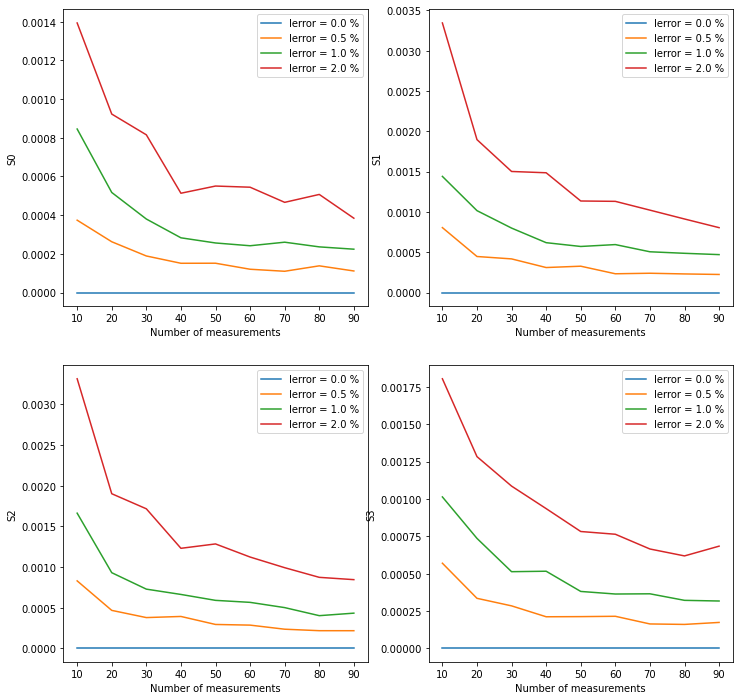

In [91]:
# Plot the results
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.plot(Ns, error[0,:,:])
plt.legend(legend)
plt.xlabel('Number of measurements')
plt.ylabel('S0')

plt.subplot(2,2,2)
plt.plot(Ns, error[1,:,:])
plt.legend(legend)
plt.xlabel('Number of measurements')
plt.ylabel('S1')

plt.subplot(2,2,3)
plt.plot(Ns, error[2,:,:])
plt.legend(legend)
plt.xlabel('Number of measurements')
plt.ylabel('S2')

plt.subplot(2,2,4)
plt.plot(Ns, error[3,:,:])
plt.legend(legend)
plt.xlabel('Number of measurements')
plt.ylabel('S3')

These plots show that the error in the determination of the Stokes vectors is proportional to the initial error amplitude, and can be decreased increasing the number of measurements.